In [1]:
import warnings

# Ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model  import ARIMA


In [138]:
def wrangle(data_path, ID):
    
    data = pd.read_csv(data_path)
    
    df1 =  data[data.ID==ID]

    df = df1.copy()
    # Convert the currency to USD for all of them
    df.loc[df["currency"] == "USD", "cost_zar"] = df["cost"] * 19.18
    df.loc[df["currency"] != "USD", "cost_zar"] = df["cost"]
    df = df.drop(["cost", "ID", "currency", "display_location", "call_type", "call_status", "start_time" ,"end_time", "duration"], axis=1)
    df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

    
    #filling_ad_type
    ad_1 = df[df.ad_type == "EXPANDED_TEXT_AD"]
    ad_2 = df[df.ad_type == "EXPANDED_DYNAMIC_SEARCH_AD"]
    ad_3 = df[df.ad_type == "RESPONSIVE_SEARCH_AD"]

    def determine_ad_type(row):
        if pd.isnull(row["ad_type"]):
            if row["headline1_len"] in range(0, 2):
                return "EXPANDED_DYNAMIC_SEARCH_AD"
            elif ((ad_1.headline1_len.mean() - ad_1.headline1_len.std()) <= row["headline1_len"] <= ad_1.headline1_len.mean() + ad_1.headline1_len.std()) and \
                (ad_1.headline2_len.mean() - ad_1.headline2_len.std() <= row["headline2_len"] <= ad_1.headline2_len.mean() + ad_1.headline2_len.std()) and \
                (ad_1.ad_description_len.mean() - ad_1.ad_description_len.std() <= row["ad_description_len"] <= ad_1.ad_description_len.mean() + ad_1.ad_description_len.std()):
                return "EXPANDED_TEXT_AD"
            elif ((ad_3.headline1_len.mean() - ad_3.headline1_len.std()) <= row["headline1_len"] <= ad_3.headline1_len.mean() + ad_3.headline1_len.std()) and \
                (ad_3.headline2_len.mean() - ad_3.headline2_len.std() <= row["headline2_len"] <= ad_3.headline2_len.mean() + ad_3.headline2_len.std()) and \
                (ad_3.ad_description_len.mean() - ad_3.ad_description_len.std() <= row["ad_description_len"] <= ad_3.ad_description_len.mean() + ad_3.ad_description_len.std()):
                return "RESPONSIVE_SEARCH_AD"
            else:
                return row["ad_type"]  # Garde la valeur existante si aucune condition n'est remplie
        else:
            return row["ad_type"]

    df["ad_type"] = df.apply(determine_ad_type, axis=1)


    data = df.copy().set_index("date")
    
    ## Resampling
    campains_data = data.drop(columns = ["headline1_len", "headline2_len", "ad_description_len"])
    ad_characteristics = data[["headline1_len", "headline2_len", "ad_description_len"]]
    campains_data_resampled = campains_data.resample("D").sum().fillna(method = "bfill")
    ad_characteristics_resampled = round(ad_characteristics.resample("D").mean()+0.5, 0).fillna(method = "ffill")
    data = pd.concat([campains_data_resampled, ad_characteristics_resampled], axis=1)
    
    #def ad_type_per_week(data)
        # Create new variables for ad_type
    data["EXPANDED_TEXT_AD"] = data["ad_type"].str.contains("EXPANDED_TEXT_AD")
    data["EXPANDED_DYNAMIC_SEARCH_AD"] = data["ad_type"].str.contains("EXPANDED_DYNAMIC_SEARCH_AD")
    data["RESPONSIVE_SEARCH_AD"] = data["ad_type"].str.contains("RESPONSIVE_SEARCH_AD")
    data[["EXPANDED_TEXT_AD", "EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"]] = data[["EXPANDED_TEXT_AD", "EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"]].fillna(False)
    data.drop("ad_type", axis=1, inplace=True)
    
    data = data.astype(int)

    return data

In [141]:
data = wrangle("Data/Train.csv", "ID_5da86e71bf5dee4cf5047046")
data.head()

,impressions,clicks,conversions,impression_share,conversions_calls,cost_zar,headline1_len,headline2_len,ad_description_len,EXPANDED_TEXT_AD,EXPANDED_DYNAMIC_SEARCH_AD,RESPONSIVE_SEARCH_AD
date,,,,,,,,,,,,
2020-01-01,393,36,0,97,0,8087,2,4,12,1,0,0
2020-01-02,395,50,0,97,0,9831,2,4,12,1,0,0
2020-01-03,404,54,0,125,0,9774,2,4,12,1,0,0
2020-01-04,476,47,0,126,0,8217,2,4,12,1,0,0
2020-01-05,466,59,0,143,0,10806,2,4,12,1,0,0


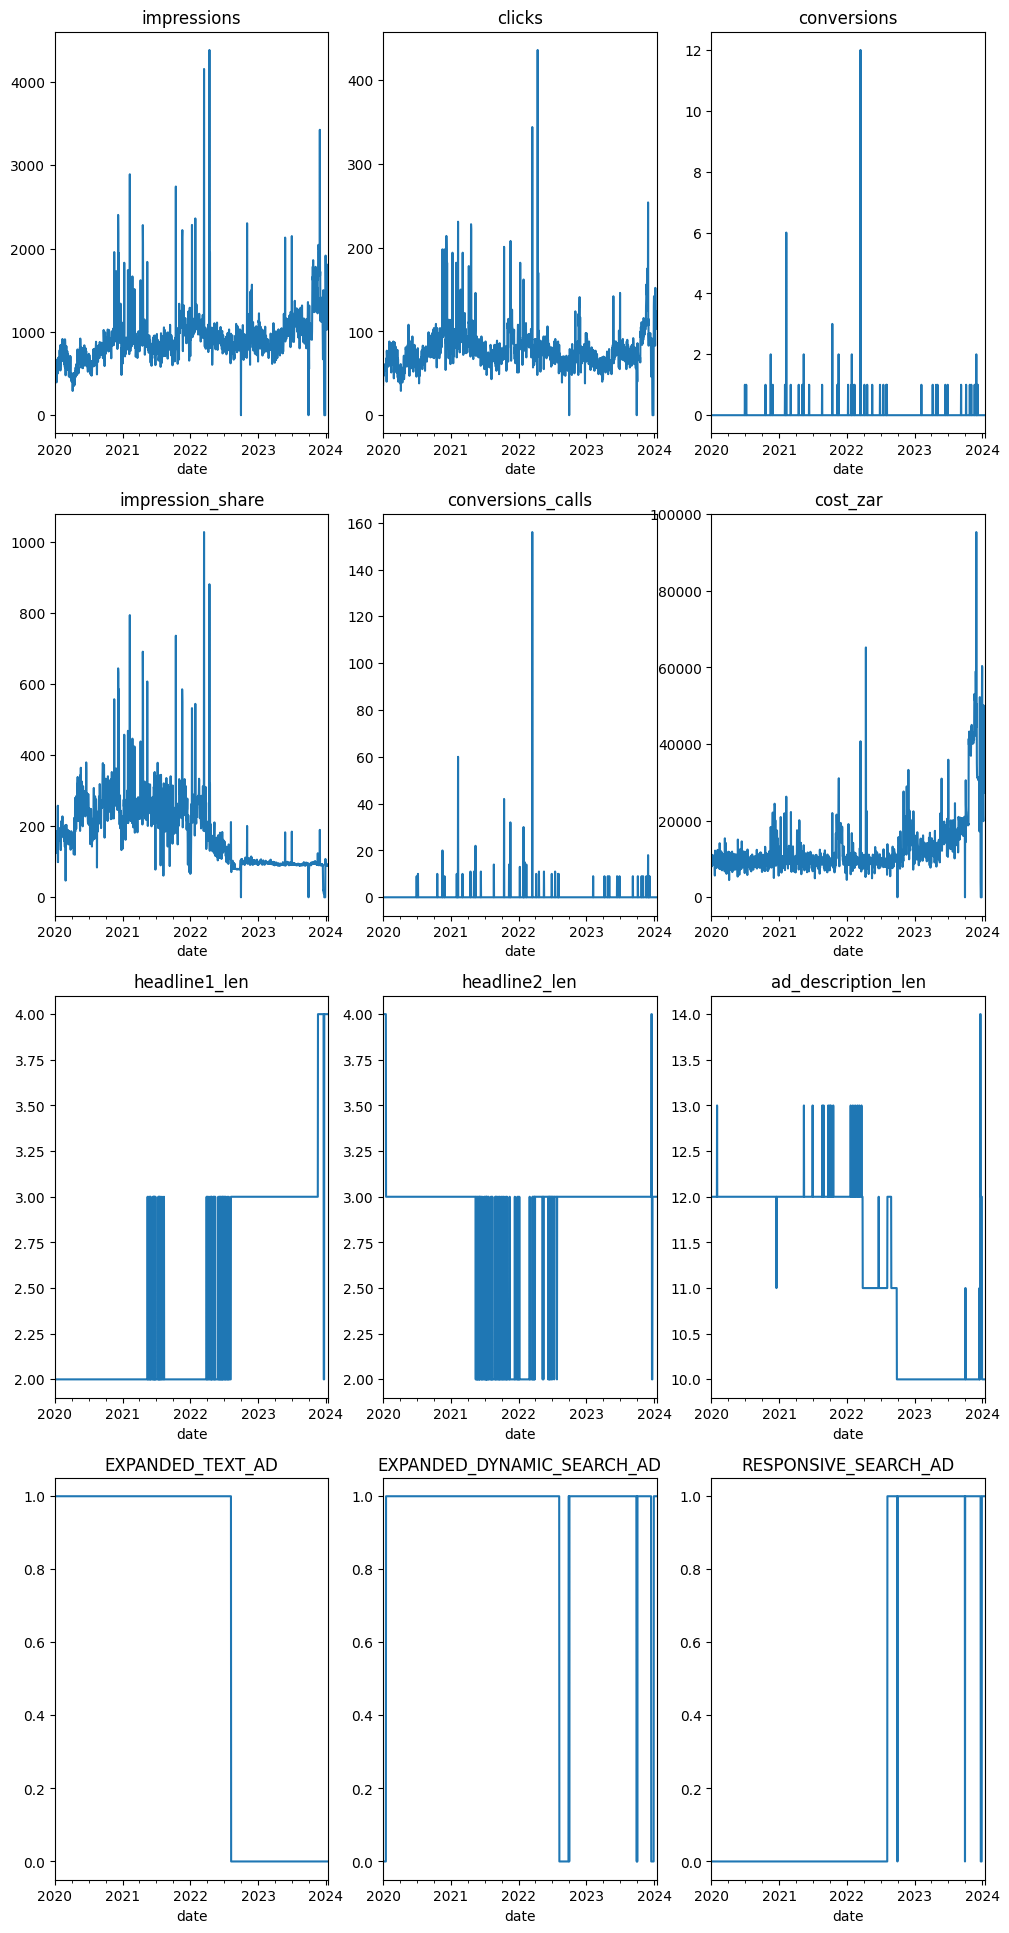

In [43]:
fig, ax = plt.subplots(figsize=(12, length_rows:= 6 * int(len(data.columns.to_list())/3)), nrows=int(length_rows/6), ncols=3)

for i, col in enumerate(data.columns):
    data[col].plot(ax=ax[i//3, i%3], title = col);

In [142]:
cutt_off= int(len(data)*0.8)
y_test = data.clicks.iloc[cutt_off:]
data = data.iloc[:cutt_off]

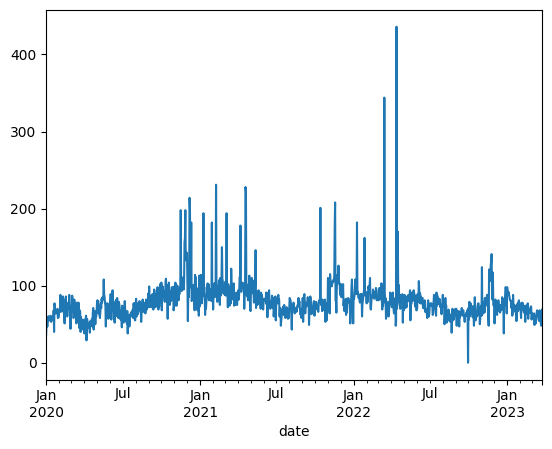

In [143]:
data.clicks.plot();

In [144]:
data[data.cost_zar ==0]

,impressions,clicks,conversions,impression_share,conversions_calls,cost_zar,headline1_len,headline2_len,ad_description_len,EXPANDED_TEXT_AD,EXPANDED_DYNAMIC_SEARCH_AD,RESPONSIVE_SEARCH_AD
date,,,,,,,,,,,,
2022-09-30,0,0,0,0,0,0,3,3,10,0,0,0


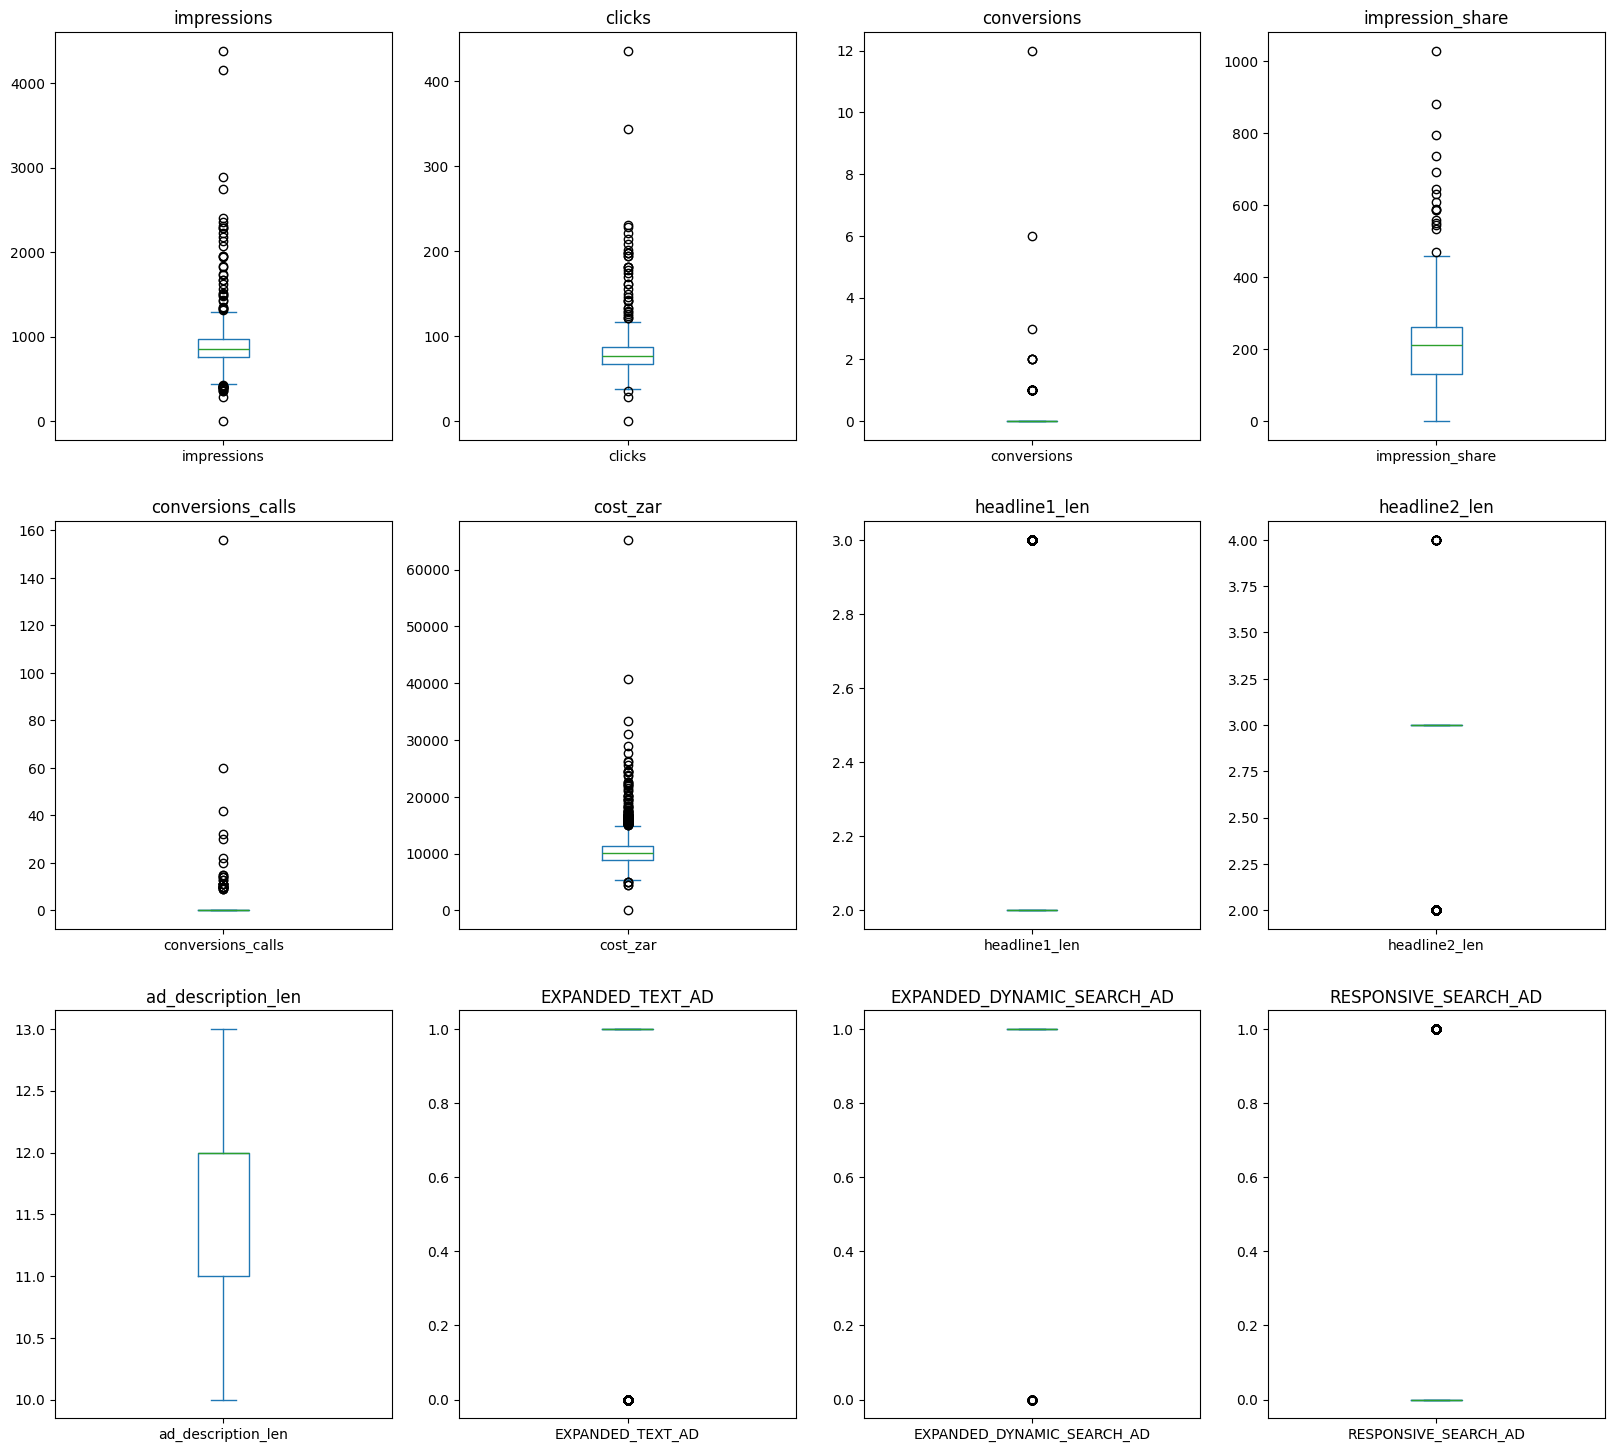

In [145]:
fig, ax = plt.subplots(figsize=(20, 18), nrows=3, ncols=4)
for i, col in enumerate(data.columns):
    data[col].plot(kind="box", ax=ax[i//4, i%4], title=col);

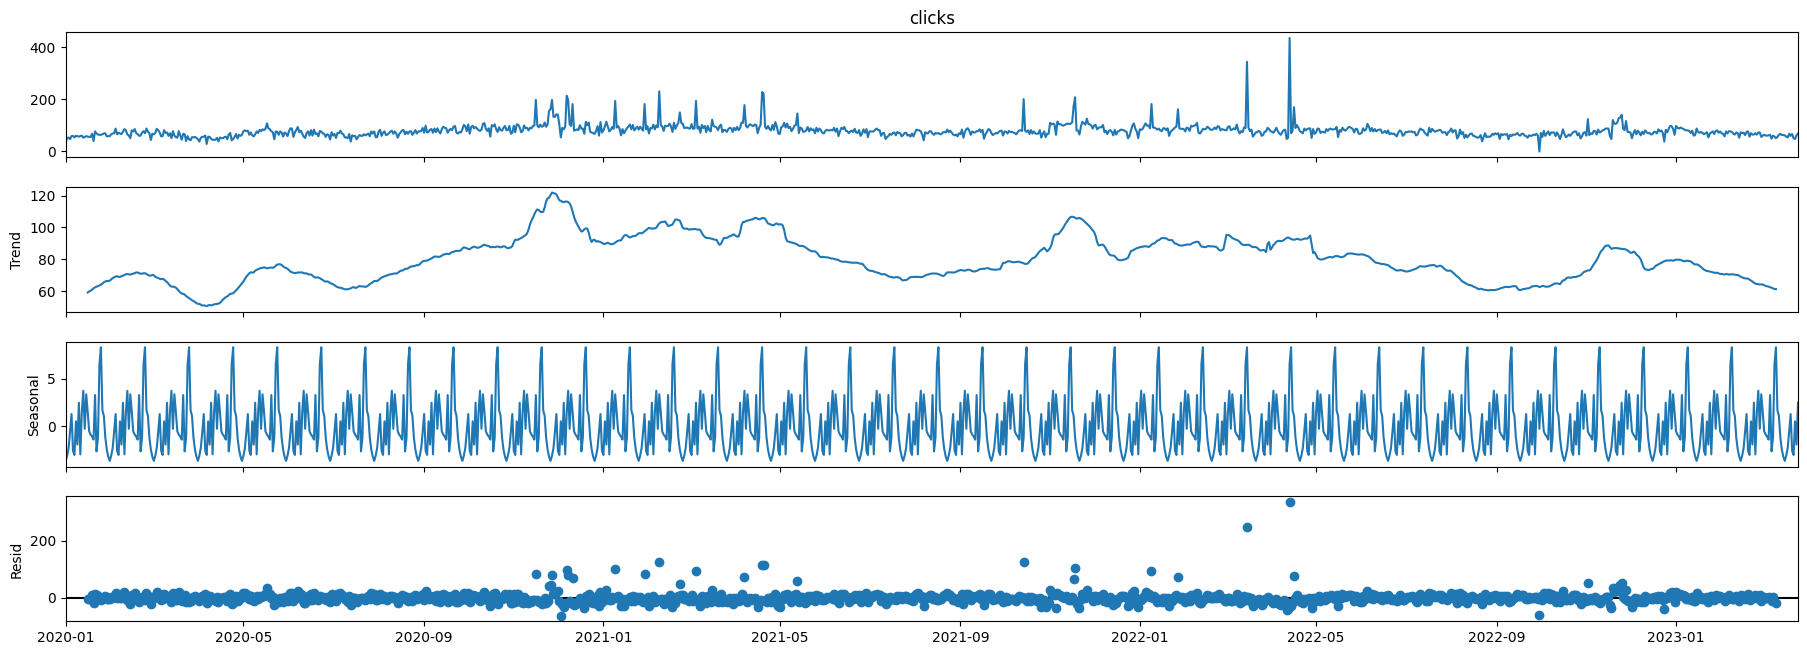

In [146]:
result = seasonal_decompose(data.clicks, period=30)
fig = result.plot()
fig.set_size_inches(20, 7)

(-3.866720328035654,
 0.0022938863495795803,
 13,
 1166,
 {'1%': -3.4359707158251345,
  '5%': -2.864021955976527,
  '10%': -2.568091448619991},
 10458.986735852464)

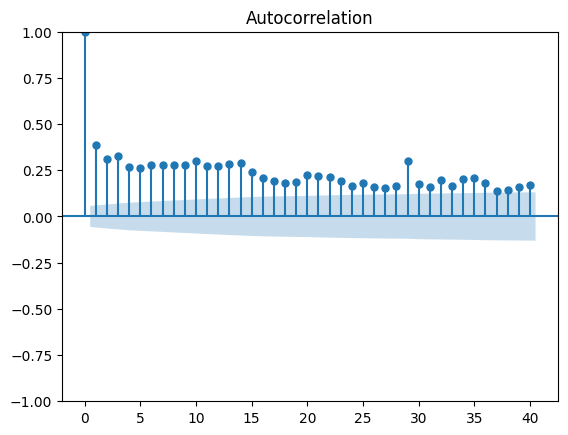

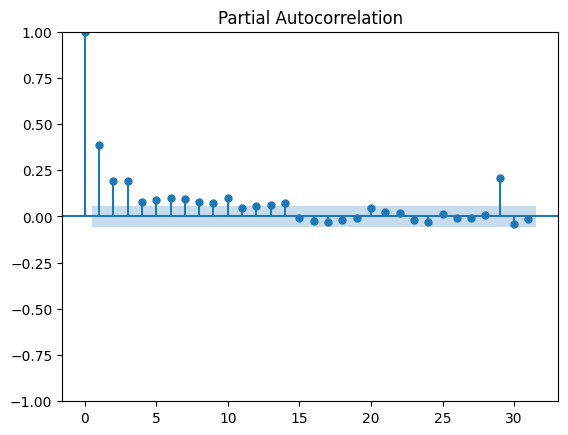

In [179]:
plot_acf(data.clicks, lags=40);
plot_pacf(data.clicks);
adfuller(data.clicks)

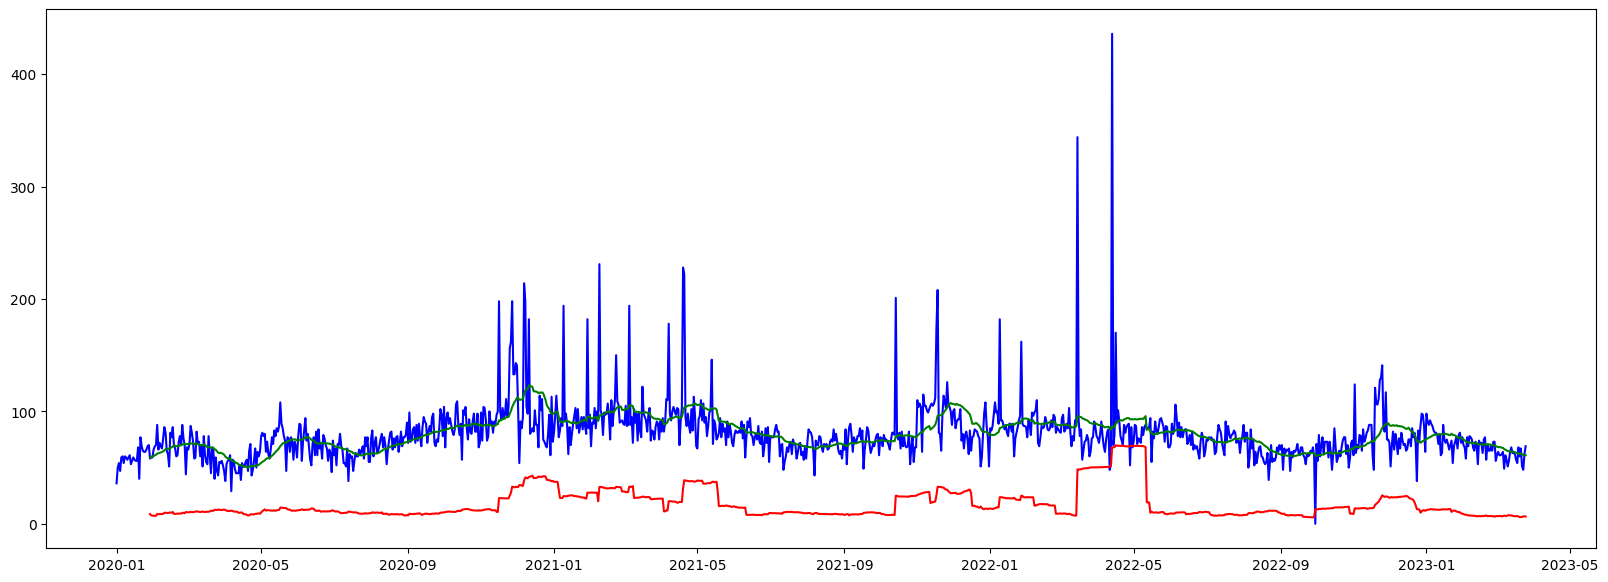

In [198]:
rolling_mean = data["clicks"].rolling(window=29).mean()
rolling_std = data["clicks"].rolling(window=29).std()
plt.figure(figsize=(20, 7))
plt.plot(data["clicks"], "b-", label = "Original")
plt.plot(rolling_mean, "g-", label = "Mean")
plt.plot(rolling_std, "r-", label = "Std")
plt.show()

In [182]:
def get_stationarity(timeseries):
    
    # Statistiques mobiles
    rolling_mean = timeseries.rolling(window=29).mean()
    rolling_std = timeseries.rolling(window=29).std()
    
    # Set the dimensions of the plot window
    plt.figure(figsize=(15, 7))
    
    # tracé statistiques mobiles
    original = plt.plot(timeseries, color='blue', label='Origine')
    mean = plt.plot(rolling_mean, color='red', label='Moyenne Mobile')
    std = plt.plot(rolling_std, color='green', label='Ecart-type Mobile')
    plt.legend(loc='best')
    plt.title('Moyenne et écart-type Mobiles')
    plt.show(block=False)
    
    # Test Dickey–Fuller :
    result = adfuller(timeseries)
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('Valeurs Critiques :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

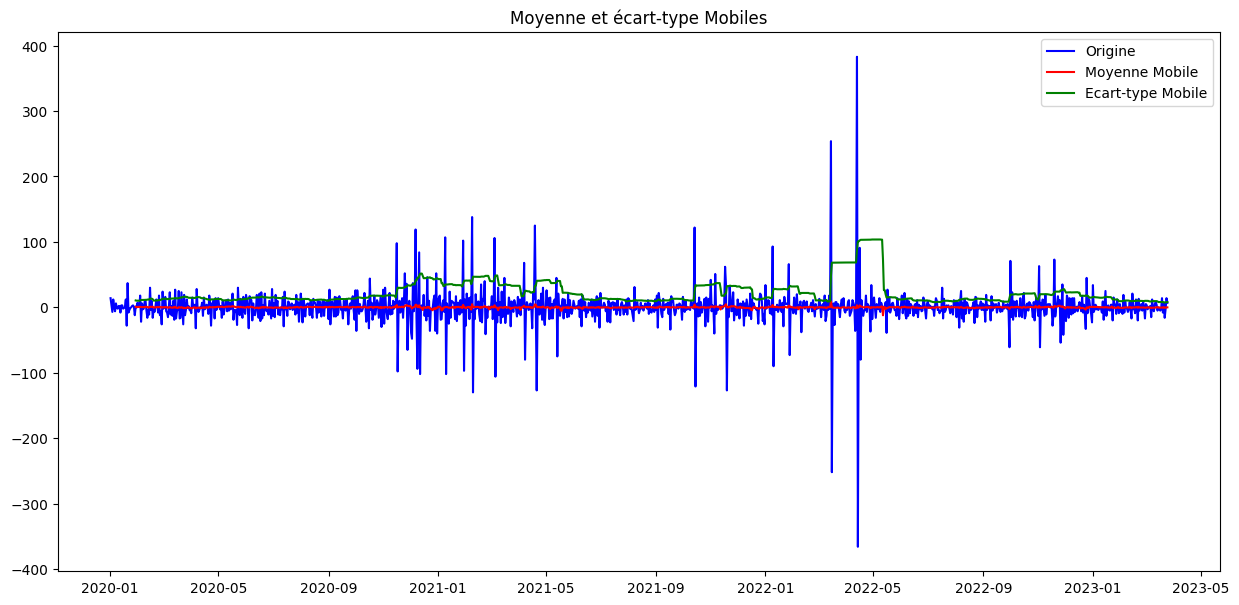

Statistiques ADF : -16.397700698645444
p-value : 2.6565844454311906e-29
Valeurs Critiques :
	1%: -3.4359707158251345
	5%: -2.864021955976527
	10%: -2.568091448619991


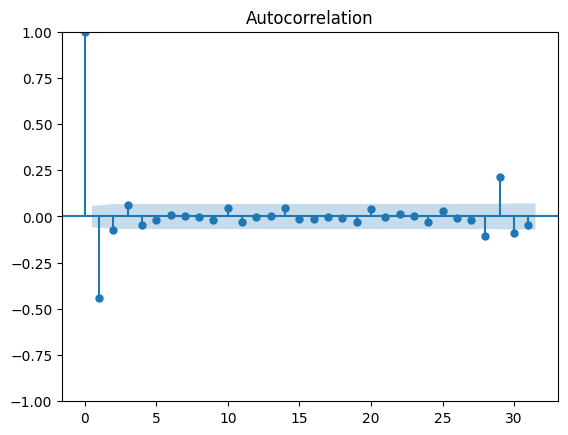

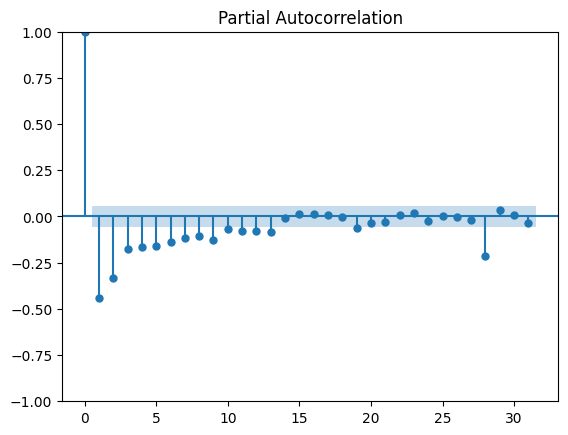

In [201]:
z = data.clicks - data.clicks.shift(1)
z.dropna(inplace= True)
get_stationarity(z)
plot_acf(z);
plot_pacf(z);

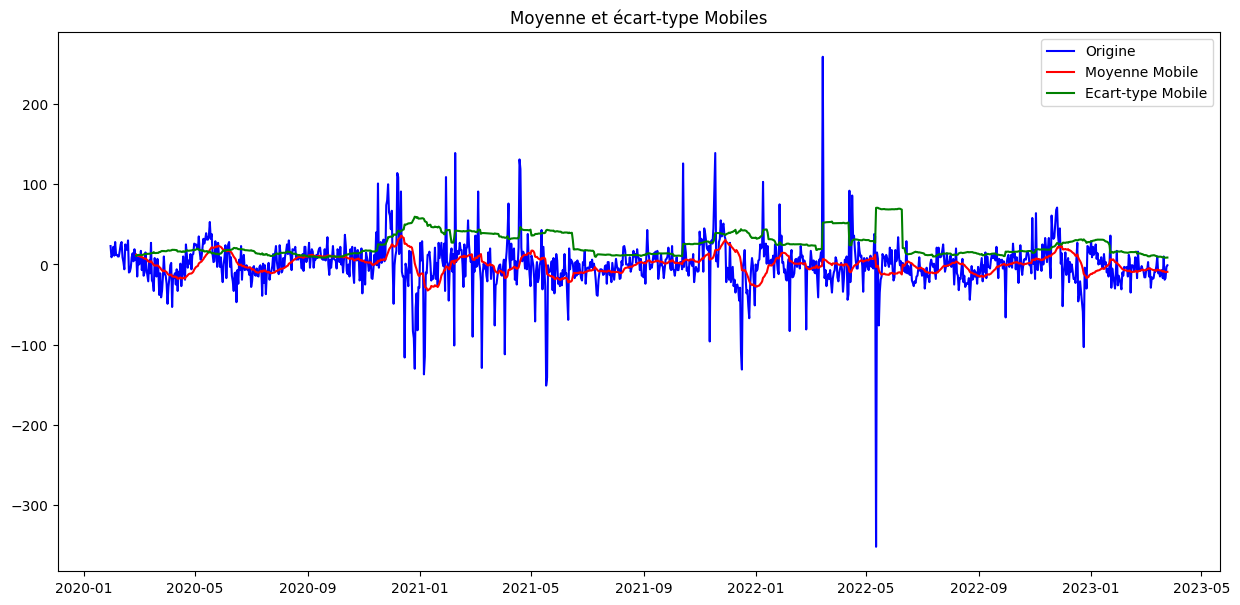

Statistiques ADF : -7.2915299410223104
p-value : 1.4130686827002593e-10
Valeurs Critiques :
	1%: -3.436139921033549
	5%: -2.86409660029079
	10%: -2.568131202693254


In [185]:
z_30 = data.clicks - data.clicks.shift(29)
z_30.dropna(inplace= True)
get_stationarity(z_30)

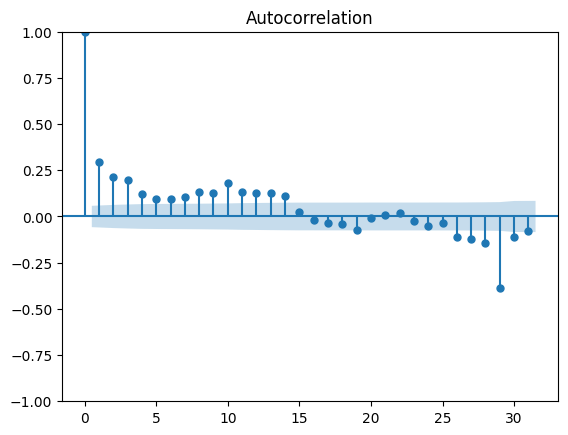

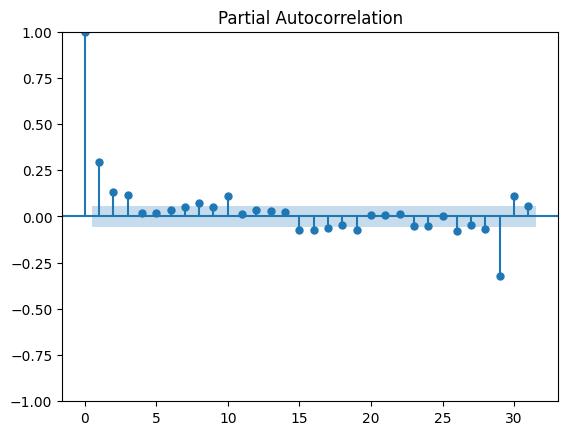

In [186]:
plot_acf(z_30);
plot_pacf(z_30);

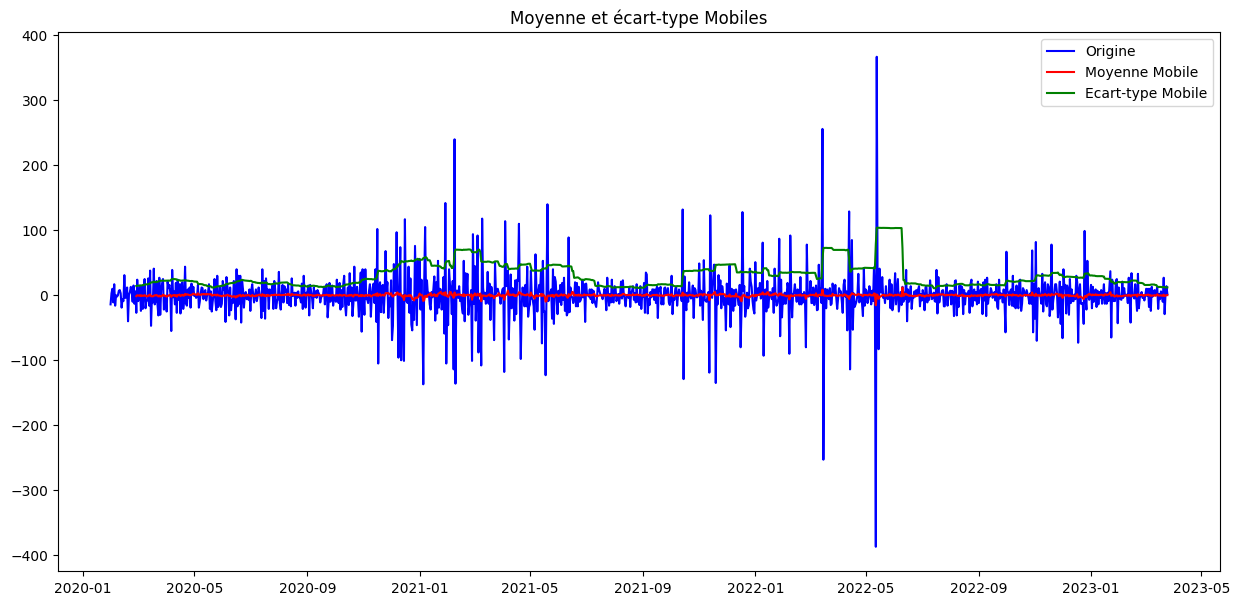

Statistiques ADF : -15.444897808768351
p-value : 2.8333488710149617e-28
Valeurs Critiques :
	1%: -3.436114401808766
	5%: -2.8640853428381092
	10%: -2.568125207156112


In [189]:
z_30_1 = z_30 - z_30.shift(1)
z_30_1.dropna(inplace= True)
get_stationarity(z_30_1)

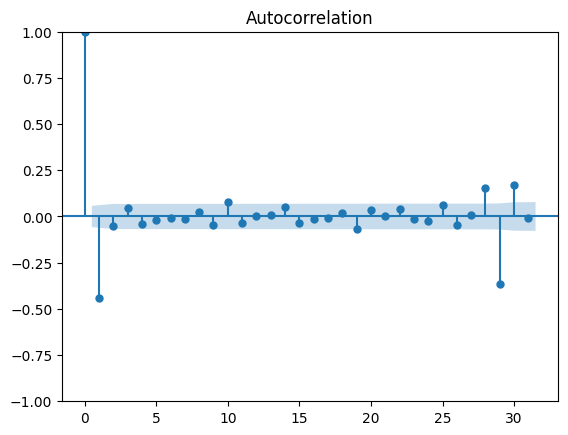

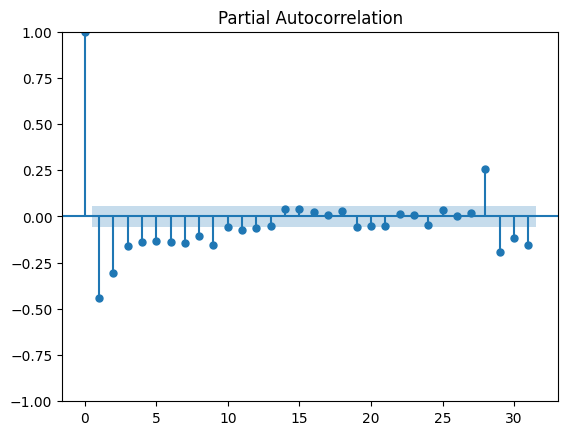

In [190]:
plot_acf(z_30_1);
plot_pacf(z_30_1);

In [193]:
data_to_work_numerics = data.select_dtypes("number")
data_to_work_numerics.corr().style.background_gradient()

,impressions,clicks,conversions,impression_share,conversions_calls,cost_zar,headline1_len,headline2_len,ad_description_len,EXPANDED_TEXT_AD,EXPANDED_DYNAMIC_SEARCH_AD,RESPONSIVE_SEARCH_AD
impressions,1.000000,0.855529,0.466855,0.529223,0.470722,0.697498,0.023383,-0.246390,-0.072349,-0.031848,0.115665,0.039223
clicks,0.855529,1.000000,0.404866,0.639250,0.404193,0.712059,-0.184090,-0.117235,0.119389,0.182335,0.195830,-0.175295
conversions,0.466855,0.404866,1.000000,0.373935,0.992749,0.288051,-0.049350,-0.062113,0.038784,0.046407,0.025570,-0.046407
impression_share,0.529223,0.639250,0.373935,1.000000,0.374678,0.220122,-0.546071,-0.307533,0.593496,0.581082,0.290919,-0.576282
conversions_calls,0.470722,0.404193,0.992749,0.374678,1.000000,0.290751,-0.048493,-0.076166,0.040950,0.045435,0.024409,-0.045435
cost_zar,0.697498,0.712059,0.288051,0.220122,0.290751,1.000000,0.228543,-0.012419,-0.287127,-0.281489,0.057959,0.289652
headline1_len,0.023383,-0.184090,-0.049350,-0.546071,-0.048493,0.228543,1.000000,0.153028,-0.784664,-0.878043,-0.300438,0.878043
headline2_len,-0.246390,-0.117235,-0.062113,-0.307533,-0.076166,-0.012419,0.153028,1.000000,-0.269792,-0.240506,-0.251934,0.240506
ad_description_len,-0.072349,0.119389,0.038784,0.593496,0.040950,-0.287127,-0.784664,-0.269792,1.000000,0.820449,0.015232,-0.814810
EXPANDED_TEXT_AD,-0.031848,0.182335,0.046407,0.581082,0.045435,-0.281489,-0.878043,-0.240506,0.820449,1.000000,0.350733,-0.994600


In [194]:
vif_data = pd.DataFrame()
vif_data["VIF"] = [variance_inflation_factor(data_to_work_numerics.drop(columns="clicks").values, i) for i in range(len(data_to_work_numerics.drop(columns="clicks").columns))]
vif_data["Feature Name"] = data_to_work_numerics.drop(columns="clicks").columns
vif_data

,VIF,Feature Name
0,35.143550,impressions
1,71.231432,conversions
2,19.231671,impression_share
3,71.248449,conversions_calls
4,0.164516,cost_zar
5,107.066537,headline1_len
6,45.450982,headline2_len
7,495.036368,ad_description_len
8,498.041648,EXPANDED_TEXT_AD
9,24.338987,EXPANDED_DYNAMIC_SEARCH_AD


In [195]:
target = "clicks"
X = data.drop(target, axis =1).astype(int)
#X"EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"]] = X[["EXPANDED_TEXT_AD", "EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"]].astype(int) 
y = data[target]

In [196]:
display(X.head(), y.head())

,impressions,conversions,impression_share,conversions_calls,cost_zar,headline1_len,headline2_len,ad_description_len,EXPANDED_TEXT_AD,EXPANDED_DYNAMIC_SEARCH_AD,RESPONSIVE_SEARCH_AD
date,,,,,,,,,,,
2020-01-01,393,0,97,0,8087,2,4,12,1,0,0
2020-01-02,395,0,97,0,9831,2,4,12,1,0,0
2020-01-03,404,0,125,0,9774,2,4,12,1,0,0
2020-01-04,476,0,126,0,8217,2,4,12,1,0,0
2020-01-05,466,0,143,0,10806,2,4,12,1,0,0


date
2020-01-01    36
2020-01-02    50
2020-01-03    54
2020-01-04    47
2020-01-05    59
Freq: D, Name: clicks, dtype: int32

In [203]:
def optimize_SARIMAX(endog, exog, order_list, seasonal_order_list):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        endog - the observed variable
    """
    
    results = []
    
    for order in order_list:
        for seasonal_order in seasonal_order_list:    
            try: 
                model = SARIMAX(endog, exog, order=order, seasonal_order = seasonal_order, simple_differencing=True, freq="D").fit(disp=False)
            except:
                continue
                
            #aic = model.aic
            results.append([order, seasonal_order, model.aic, model.bic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', "P, D, Q", 'AIC', "BIC"]
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [205]:
def optimize_ARIMAX(endog, exog, order_list):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        endog - the observed variable
    """
    
    results = []
    
    for order in order_list:
        try: 
            model = ARIMA(endog, exog, order=order, freq="D").fit()
        except:
            continue
            
        #aic = model.aic
        results.append([order, model.aic, model.bic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC', "BIC"]
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [209]:
from itertools import product

ps = range(1,14, 3)
d = 1
qs = range(0, 3)

Ps = range(0, 8, 3)
D=1
Qs = range(0,2)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

seasonal_parameters = product(Ps, Qs)
seasonal_parameters_list = list(seasonal_parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)

seasonal_order_list = []


for each in seasonal_parameters_list:
    each = list(each)
    each.append(29)
    each.insert(1, D)
    each = tuple(each)
    seasonal_order_list.append(each)

order_list, seasonal_order_list

([(1, 1, 0),
  (1, 1, 1),
  (1, 1, 2),
  (4, 1, 0),
  (4, 1, 1),
  (4, 1, 2),
  (7, 1, 0),
  (7, 1, 1),
  (7, 1, 2),
  (10, 1, 0),
  (10, 1, 1),
  (10, 1, 2),
  (13, 1, 0),
  (13, 1, 1),
  (13, 1, 2)],
 [(0, 1, 0, 29),
  (0, 1, 1, 29),
  (3, 1, 0, 29),
  (3, 1, 1, 29),
  (6, 1, 0, 29),
  (6, 1, 1, 29)])

In [206]:
result_df1 = optimize_ARIMAX(y,X, order_list)
result_df1

c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p, d, q)",AIC,BIC
0,"(7, 0, 0)",8239.863517,8341.328911
1,"(7, 0, 1)",8245.194869,8351.733533
2,"(10, 0, 0)",8258.183788,8374.868991
3,"(10, 0, 1)",8265.423602,8387.182076
4,"(4, 0, 0)",8271.819091,8358.064676
5,"(4, 0, 1)",8297.734440,8389.053295
6,"(1, 0, 1)",8310.615309,8386.714354
7,"(1, 0, 0)",8336.143212,8407.168988


In [ ]:
result_df = optimize_SARIMAX(y,X, order_list, seasonal_order_list)
result_df

                               SARIMAX Results                                
Dep. Variable:                 clicks   No. Observations:                 1180
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -4154.072
Date:                Tue, 07 May 2024   AIC                           8336.143
Time:                        03:29:56   BIC                           8407.169
Sample:                    01-01-2020   HQIC                          8362.920
                         - 03-25-2023                                         
Covariance Type:                  opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -52.7404     19.155     -2.753      0.006     -90.283     -15.198
impressions                    0.0286      0.002     17.401      0.000       0.025 

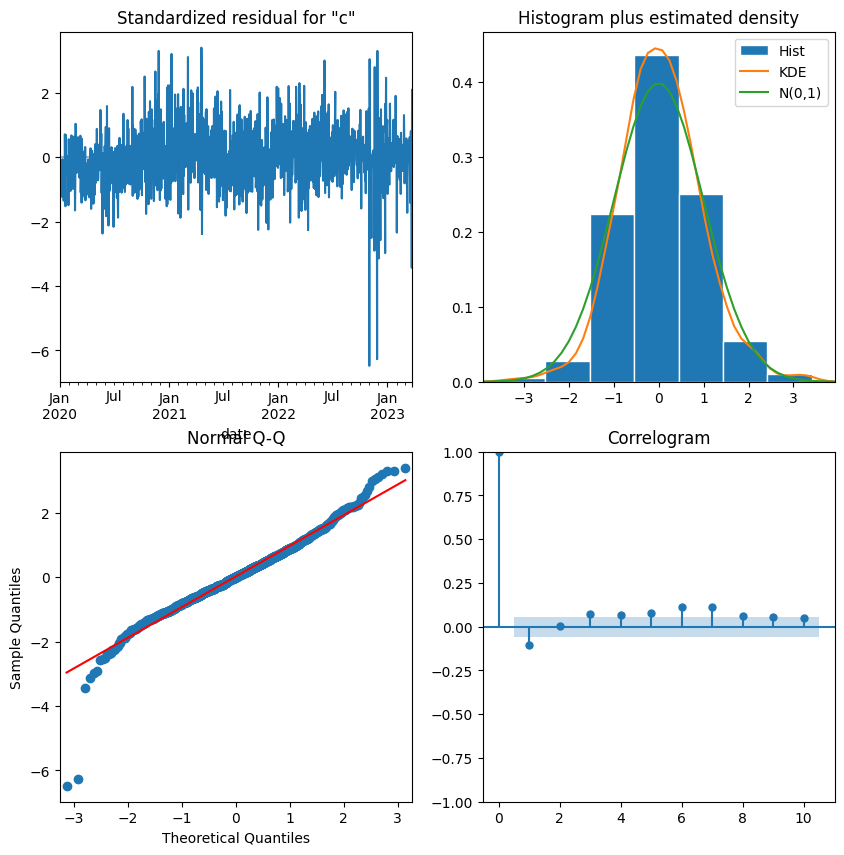

In [208]:
good_model = ARIMA(endog=y, exog=X, order=(1,0,0), freq="D").fit()
print(good_model.summary())
good_model.plot_diagnostics(figsize=(10, 10));